In [3]:
import numpy as np
import tensorflow as tf
import os
import h5py
from PIL import Image

2025-03-12 13:00:54.366289: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-12 13:00:54.517021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741780854.565369   86303 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741780854.581684   86303 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1741780854.752870   86303 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [4]:
CANCER_TYPES = {
    1: 'Oponiak',
    2: 'Glejak',
    3: 'Guz przysadki'
}

IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256

In [5]:
data_dir = 'data'
mri_images = []
labels = []
borders = []

for file_name in os.listdir(data_dir):
    file_path = os.path.join(data_dir, file_name)
    file_mat = h5py.File(file_path, "r")
    image = np.array(file_mat['/cjdata/image'])
    image = Image.fromarray(image).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    mri_images.append(np.array(image))
    labels.append(file_mat['/cjdata/label'][0][0])
    borders.append(file_mat['/cjdata/tumorBorder'][0])

In [6]:
mri_images = np.array(mri_images) / 255
labels = np.array(labels, dtype=np.int32) - 1

In [7]:
unique_values, counts = np.unique(labels, return_counts=True)
print('Unique values:', unique_values)
print(len(CANCER_TYPES))

Unique values: [0 1 2]
3


In [8]:
labels

array([2, 2, 2, ..., 2, 1, 2], dtype=int32)

In [9]:
one_hot_labels = np.eye(len(CANCER_TYPES))[labels]

In [10]:
print(one_hot_labels)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [11]:
mri_images.shape

(3064, 256, 256)

In [12]:
mri_images = np.expand_dims(mri_images, axis=-1)

In [13]:
mri_images.shape

(3064, 256, 256, 1)

In [14]:
from sklearn.model_selection import train_test_split


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    mri_images,
    one_hot_labels, 
    test_size=0.2, 
    random_state=42
)

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 1)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

/home/michal/mri/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/home/michal/mri/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1741780876.052923   86303 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [17]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
epochs = 50
model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/50


I0000 00:00:1741780885.144582   86976 service.cc:152] XLA service 0x7f5744004890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741780885.144917   86976 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-03-12 13:01:25.199192: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741780885.544738   86976 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.3785 - loss: 15.3217

I0000 00:00:1741780890.872455   86976 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


77/77 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - accuracy: 0.6562 - loss: 3.9449 - val_accuracy: 0.8173 - val_loss: 0.4478
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.8700 - loss: 0.3235 - val_accuracy: 0.8499 - val_loss: 0.3281
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9301 - loss: 0.1811 - val_accuracy: 0.8744 - val_loss: 0.2821
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.9480 - loss: 0.1449 - val_accuracy: 0.8891 - val_loss: 0.2619
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9643 - loss: 0.1034 - val_accuracy: 0.9070 - val_loss: 0.2671
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9808 - loss: 0.0596 - val_accuracy: 0.9184 - val_loss: 0.2782
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9803 - loss: 0.0532 - val_accuracy: 0.9152 - val_loss: 0.2591
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9829 - loss: 0.0433 - val_accuracy: 0.9038 - val_loss: 

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sns

In [20]:
y_pred = model.predict(X_test)
y_pred_one_hot = np.eye(y_pred.shape[1])[np.argmax(y_pred, axis=1)]
accuracy = accuracy_score(y_test, y_pred_one_hot, normalize = True)
accuracy_count = accuracy_score(y_test, y_pred_one_hot, normalize = False)
precision = precision_score(y_test, y_pred_one_hot, average = 'weighted')
recall = recall_score(y_test, y_pred_one_hot, average = 'weighted')

print(f"Accuracy: {accuracy}")
print(f"Accuracy count: {accuracy_count}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Accuracy: 0.9494290375203915
Accuracy count: 582.0
Precision: 0.9494803564296549
Recall: 0.9494290375203915


In [21]:
y_pred_one_hot

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

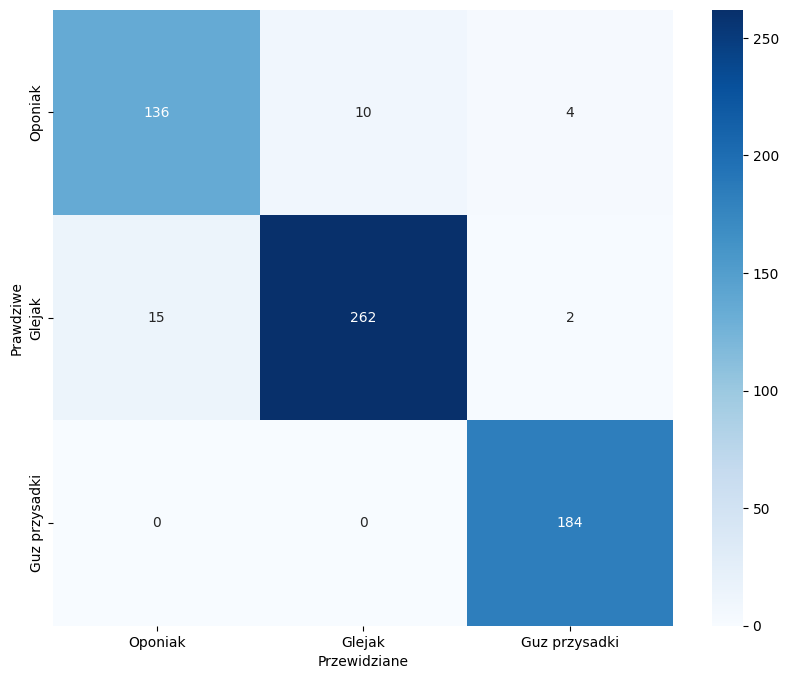

In [22]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CANCER_TYPES.values(), yticklabels=CANCER_TYPES.values())
plt.xlabel("Przewidziane")
plt.ylabel("Prawdziwe")
plt.show()

In [23]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=CANCER_TYPES.values()))


               precision    recall  f1-score   support

      Oponiak       0.90      0.91      0.90       150
       Glejak       0.96      0.94      0.95       279
Guz przysadki       0.97      1.00      0.98       184

     accuracy                           0.95       613
    macro avg       0.94      0.95      0.95       613
 weighted avg       0.95      0.95      0.95       613



In [ ]:
import shap
from skimage.segmentation import slic
from matplotlib.colors import LinearSegmentedColormap

/home/michal/mri/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [45]:
file = data_dir + '/136.mat'
file_mat = h5py.File(file, "r") 
image = np.array(file_mat['/cjdata/image'])
image = Image.fromarray(image).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
image_orig = np.array(image)
label = file_mat['/cjdata/label'][0][0]
border = file_mat['/cjdata/tumorBorder'][0]

In [46]:
image_orig = np.expand_dims(image_orig, axis=-1)

In [47]:
segments_slic = slic(image_orig, n_segments=50, compactness=30, sigma=3)

In [48]:
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out
def f(z):
    return model.predict(mask_image(z, segments_slic, image_orig, 255))

In [49]:
explainer = shap.KernelExplainer(f, np.zeros((1,50)))
shap_values = explainer.shap_values(np.ones((1,50)), nsamples=100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step 


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


In [50]:
preds = model.predict(np.expand_dims(image_orig.copy(), axis=0))
top_preds = np.argsort(-preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [51]:
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
cm = LinearSegmentedColormap.from_list("shap", colors)

In [52]:
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

0
1
2


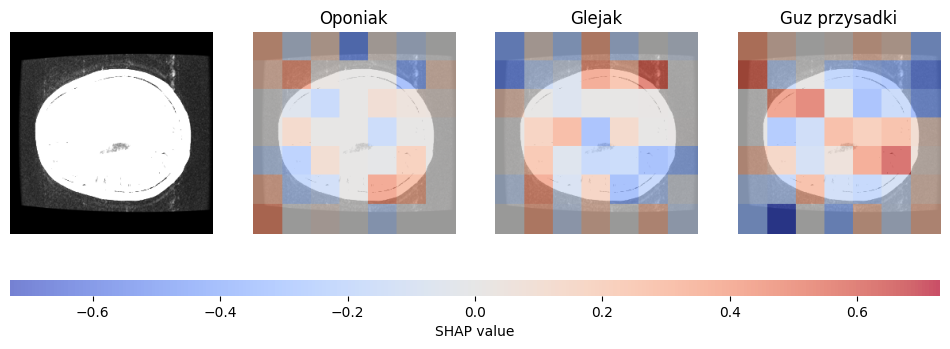

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))

inds = top_preds[0]
axes[0].imshow(image)
axes[0].axis('off')

max_val = np.max([np.max(np.abs(shap_values[0][:, j])) for j in range(shap_values.shape[-1])])

for i in range(3):
    selected_class = inds[i]
    m = fill_segmentation(shap_values[0][:, selected_class], segments_slic)
    axes[i+1].set_title(CANCER_TYPES[selected_class + 1])

    axes[i+1].imshow(image)

    im = axes[i+1].imshow(m, cmap='coolwarm', alpha=0.7, vmin=-max_val, vmax=max_val)  

    axes[i+1].axis('off')

cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()